In [1]:
import pandas as pd
import glob

In [2]:
def read_for_sale(files):
    all_files = []
    for f in files:
        df = pd.read_csv(f)
        df['UPDATED'] = str(f)
        all_files.append(df)
    return pd.concat(all_files)

In [59]:
# Create dataframes
all_for_sale = glob.glob("for_sale/*.csv")
all_sold = glob.glob("sold/*.csv")
all_reduced = glob.glob("reduced/*.csv")

df_for_sale = read_for_sale(all_for_sale)
df_reduced = read_for_sale(all_reduced)
df_sold = pd.concat(pd.read_csv(f) for f in all_sold)

In [60]:
df_for_sale.reset_index(inplace=True)
df_sold.reset_index(inplace=True)
df_reduced.reset_index(inplace=True)

In [61]:
# Clean up Updated field on for sale listings
df_for_sale['UPDATED'] = df_for_sale['UPDATED'].str.slice(start=9, stop=19)
df_for_sale['UPDATED'] = pd.to_datetime(df_for_sale['UPDATED'])

In [62]:
# Clean up Updated field on reduced listings. 
df_reduced['UPDATED'] = df_reduced['UPDATED'].str.slice(start=7, stop=17)
df_reduced['UPDATED'] = pd.to_datetime(df_reduced['UPDATED'])

In [63]:
# Drop the the columns we don't need
df_for_sale.drop(['index', 'SOLD DATE', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME', 'SOURCE', 'FAVORITE', 'INTERESTED'], axis=1, inplace=True)
df_sold.drop(['index', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME','SOURCE', 'FAVORITE', 'INTERESTED'], axis=1, inplace=True)
df_reduced.drop(['index', 'SOLD DATE', 'NEXT OPEN HOUSE START TIME', 'NEXT OPEN HOUSE END TIME','SOURCE', 'FAVORITE', 'INTERESTED'], axis=1, inplace=True)

In [64]:
# Concat reduced and sold into a single df
# ideally, we can then create the history of a property by looking up the MLS number
df_for_sale = pd.concat([df_for_sale, df_reduced])

In [65]:
# Get the rows where MLS# is duplicated
df_for_sale[df_for_sale.duplicated(['MLS#'])]

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,BEDS,BATHS,LOCATION,...,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,STATUS,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),MLS#,LATITUDE,LONGITUDE,UPDATED
530,PAST SALE,Townhouse,1717 A 14th Ave,Seattle,WA,98122,924900,2.0,2.0,Capitol Hill,...,2022.0,1.0,779.0,NaN,Pending,https://www.redfin.com/WA/Seattle/1717-14th-Av...,1926225,47.616998,-122.314539,2022-05-02
652,MLS Listing,Single Family Residential,10423 17th Ave NE,Seattle,WA,98125,875000,3.0,2.0,Victory Heights,...,1948.0,1.0,572.0,NaN,Active,https://www.redfin.com/WA/Seattle/10423-17th-A...,1925732,47.704711,-122.309999,2022-05-09
653,MLS Listing,Single Family Residential,9209 Renton Ave S,Seattle,WA,98118,912000,5.0,2.0,Rainier Beach,...,1955.0,1.0,456.0,NaN,Active,https://www.redfin.com/WA/Seattle/9209-Renton-...,1929665,47.520614,-122.273719,2022-05-09
654,MLS Listing,Single Family Residential,1107 E 72ND St,Tacoma,WA,98404,525000,4.0,2.5,Se Tacoma,...,2006.0,1.0,298.0,NaN,Active,https://www.redfin.com/WA/Tacoma/1107-E-72nd-S...,1914014,47.192003,-122.414925,2022-05-09
655,MLS Listing,Single Family Residential,910 Martin Luther King Jr Way,Seattle,WA,98122,800000,3.0,2.0,Central Area,...,1995.0,1.0,430.0,NaN,Active,https://www.redfin.com/WA/Seattle/910-Martin-L...,1928854,47.610408,-122.295887,2022-05-09
656,MLS Listing,Single Family Residential,3511 N Shirley St,Tacoma,WA,98407,550000,3.0,2.0,North Tacoma,...,1912.0,1.0,379.0,NaN,Active,https://www.redfin.com/WA/Tacoma/3511-N-Shirle...,1930017,47.280193,-122.510238,2022-05-09
657,MLS Listing,Single Family Residential,2601 N Carr St,Tacoma,WA,98403,499500,3.0,1.0,North Tacoma,...,1955.0,1.0,223.0,NaN,Active,https://www.redfin.com/WA/Tacoma/2601-N-Carr-S...,1930081,47.271158,-122.466535,2022-05-09
1077,MLS Listing,Single Family Residential,7315 19th Ave SW,Seattle,WA,98106,650000,3.0,1.5,Puget Ridge,...,1976.0,1.0,670.0,NaN,Active,https://www.redfin.com/WA/Seattle/7315-19th-Av...,1926983,47.536613,-122.359138,2022-05-12
1680,MLS Listing,Single Family Residential,10604 9th Avenue Ct S,Tacoma,WA,98444,710000,4.0,3.0,Tacoma,...,2021.0,1.0,270.0,NaN,Active,https://www.redfin.com/WA/Tacoma/10604-9th-Ave...,1927760,47.161434,-122.447335,2022-05-06
1693,MLS Listing,Condo/Co-op,737 Olive Way #2409,Seattle,WA,98101,652000,1.0,1.0,Downtown,...,2009.0,1.0,945.0,569.0,Active,https://www.redfin.com/WA/Seattle/737-Olive-Wa...,1926384,47.613645,-122.334230,2022-05-06


In [66]:
# Lookup a single MLS# to see the duplicates
df_for_sale[['ADDRESS', 'PRICE', 'UPDATED']].loc[df_for_sale['MLS#'] == 1917501]

,ADDRESS,PRICE,UPDATED
1654,425 Vine St #719,457000,2022-04-28
38,425 Vine St #719,429000,2022-05-02


In [67]:
# create final sale df
df_final_sale = df_for_sale.sort_values(by=['UPDATED'])
df_final_sale = df_final_sale.drop_duplicates(subset=['MLS#'], keep='last')

# Try to merge for sale and sold to see if sold prices are captured accurately
# are there any sold above listing price?
df_final_sale = pd.merge(df_final_sale, df_sold[['SOLD DATE', 'PRICE', 'MLS#']], how='inner', on='MLS#')
df_final_sale = df_final_sale.rename(columns={"PRICE_x": "ASKING PRICE", "PRICE_y": "SALE PRICE"})
df_final_sale['DIFF'] = df_final_sale["SALE PRICE"] - df_final_sale['ASKING PRICE']

In [68]:
df_final_sale

,SALE TYPE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,ASKING PRICE,BEDS,BATHS,LOCATION,...,HOA/MONTH,STATUS,URL (SEE https://www.redfin.com/buy-a-home/comparative-market-analysis FOR INFO ON PRICING),MLS#,LATITUDE,LONGITUDE,UPDATED,SOLD DATE,SALE PRICE,DIFF
0,MLS Listing,Single Family Residential,10833 2nd Ave S,Seattle,WA,98168,585000,2.0,1.0,Top Hat,...,NaN,Active,https://www.redfin.com/WA/Seattle/10833-2nd-Av...,1923185,47.504669,-122.331383,2022-04-28,May-16-2022,650000,65000
1,MLS Listing,Single Family Residential,1005 E 30th St,Tacoma,WA,98404,615000,3.0,2.0,Tacoma,...,NaN,Active,https://www.redfin.com/WA/Tacoma/1005-E-30th-S...,1922637,47.236026,-122.418711,2022-04-28,May-19-2022,666500,51500
2,MLS Listing,Single Family Residential,10816 12th Ave NE,Seattle,WA,98125,699950,2.0,1.0,Maple Leaf,...,NaN,Active,https://www.redfin.com/WA/Seattle/10816-12th-A...,1922628,47.707540,-122.314634,2022-04-28,May-19-2022,750000,50050
3,MLS Listing,Single Family Residential,430 26th Ave S,Seattle,WA,98144,825000,3.0,2.0,Judkins,...,NaN,Active,https://www.redfin.com/WA/Seattle/430-26th-Ave...,1923041,47.598300,-122.298446,2022-04-28,May-17-2022,847000,22000
4,MLS Listing,Single Family Residential,3619 Larchmont Ave NE,Tacoma,WA,98422,699950,3.0,2.5,Browns Point,...,NaN,Active,https://www.redfin.com/WA/Tacoma/3619-Larchmon...,1919776,47.290041,-122.399858,2022-04-28,May-20-2022,685000,-14950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,MLS Listing,Single Family Residential,13535 39th Ave NE,Seattle,WA,98125,599995,3.0,2.0,Cedar Park,...,NaN,Active,https://www.redfin.com/WA/Seattle/13535-39th-A...,1927939,47.727412,-122.287196,2022-05-05,May-23-2022,770000,170005
64,MLS Listing,Condo/Co-op,914 6th Ave N #401,Seattle,WA,98109,565000,2.0,1.5,Queen Anne,...,530.0,Active,https://www.redfin.com/WA/Seattle/914-6th-Ave-...,1923875,47.627667,-122.344620,2022-05-06,May-20-2022,575000,10000
65,MLS Listing,Vacant Land,6031 S Cedar St,Tacoma,WA,98409,149000,NaN,NaN,Tacoma,...,NaN,Active,https://www.redfin.com/WA/Tacoma/6031-S-Cedar-...,1929757,47.201438,-122.475638,2022-05-08,May-19-2022,163500,14500
66,MLS Listing,Single Family Residential,3024 S 11th St,Tacoma,WA,98405,350000,3.0,1.0,Central Tacoma,...,NaN,Active,https://www.redfin.com/WA/Tacoma/3024-S-11th-S...,1929192,47.250638,-122.476085,2022-05-08,May-23-2022,400000,50000


In [73]:
# Calc summary stats
# mean over price
avg_over = df_final_sale["DIFF"].loc[df_final_sale['DIFF'] > 0].mean()
print(avg_over)

78592.95918367348


In [75]:
# % of properties over asking
perc_over = (df_final_sale["DIFF"].loc[df_final_sale['DIFF'] > 0].count() / df_final_sale["DIFF"].count())*100
print(perc_over)

72.05882352941177


In [81]:
import matplotlib.pyplot as plt

array([[<AxesSubplot:xlabel='ASKING PRICE', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='BEDS', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='BATHS', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='HOA/MONTH', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='$/SQUARE FEET', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='SALE PRICE', ylabel='ASKING PRICE'>,
        <AxesSubplot:xlabel='DIFF', ylabel='ASKING PRICE'>],
       [<AxesSubplot:xlabel='ASKING PRICE', ylabel='BEDS'>,
        <AxesSubplot:xlabel='BEDS', ylabel='BEDS'>,
        <AxesSubplot:xlabel='BATHS', ylabel='BEDS'>,
        <AxesSubplot:xlabel='HOA/MONTH', ylabel='BEDS'>,
        <AxesSubplot:xlabel='$/SQUARE FEET', ylabel='BEDS'>,
        <AxesSubplot:xlabel='SALE PRICE', ylabel='BEDS'>,
        <AxesSubplot:xlabel='DIFF', ylabel='BEDS'>],
       [<AxesSubplot:xlabel='ASKING PRICE', ylabel='BATHS'>,
        <AxesSubplot:xlabel='BEDS', ylabel='BATHS'>,
        <AxesSubplot:xlabel='BATHS', ylabe

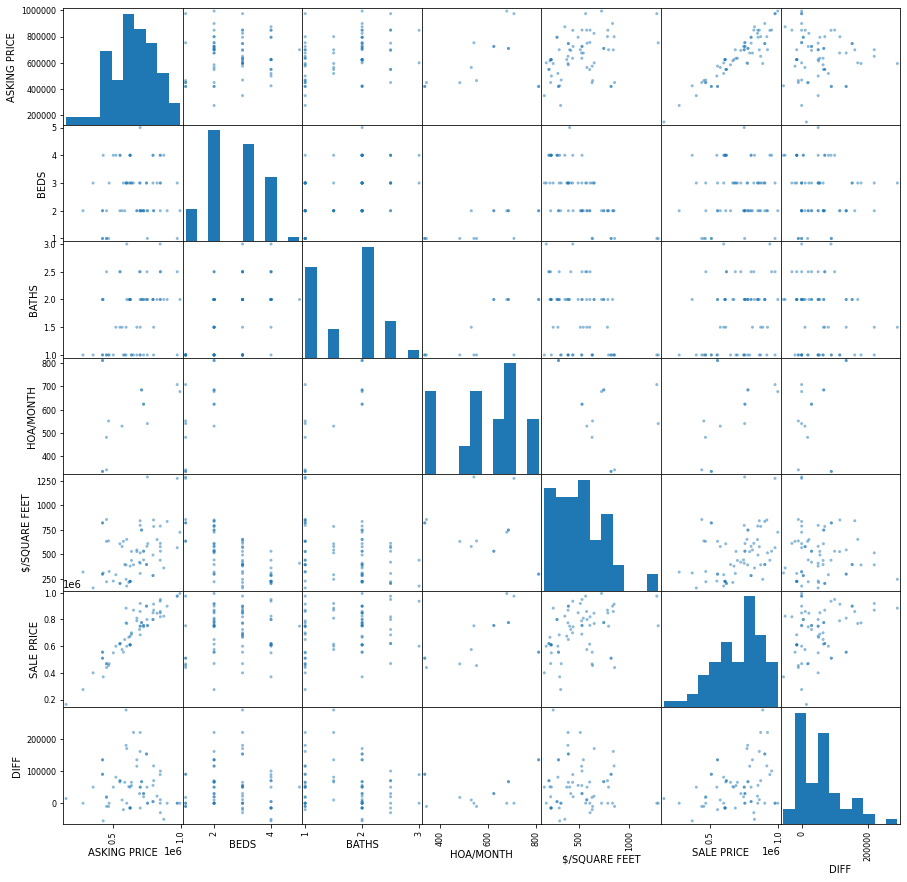

In [88]:
scatter_matrix(df_final_sale[["CITY", "ASKING PRICE", "BEDS", "BATHS", "HOA/MONTH", "$/SQUARE FEET", "SALE PRICE", "DIFF"]], figsize=(15,15))